In [1]:
%matplotlib inline
import datacube
import xarray as xr
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
import imp
from time import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
dc = datacube.Datacube(app = 'ALOS Demo', config = '/home/localuser/.datacube.conf')

### Loading Data from Landsat 8 and ALOS PALSAR

In [2]:
platforms        = ['ALOS_2', 'LANDSAT_8']
sent_product_types   = 'alos2_palsar_vietnam'
lsat_product_types   = 'ls8_lasrc_vietnam'

min_lon = 106.976139
max_lon = 107.337043
min_lat = 11.06
max_lat = 11.295810

start_date      = datetime.strptime('2000-1-1', '%Y-%m-%d')
end_date        = datetime.strptime('2017-12-31', '%Y-%m-%d')

alos = dc.load(platform=platforms[0],
                          product=sent_product_types,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat))
landsat = dc.load(platform=platforms[1],
                          product=lsat_product_types,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat)) 

### Training a new classifier from the given extents
##### We currently only have ALOS acquisitions that are yearly mosaics, taken years prior to the earliest landsat acquisition. The ALOS and Landsat acquisitions used to train the classifier can therefore differ wildly. In order to train an effective classifier, then, we train many classifiers and use the best one.

In [3]:
from utils.data_cube_utilities import wasard
alos_classifier_lst = wasard.get_best_classifier(n_classifiers = 10, sar_dataset = alos, landsat_dataset = landsat)

##### After examining multiple classifiers, we have chose the following because of its high precision and recall. 

In [4]:
alos_classifier = alos_classifier_lst[1]

In [5]:
alos_classifier.precision

0.87947999302326985

In [6]:
alos_classifier.recall

0.85157178131333133

### Using the classifier to run water detection on every ALOS scene in the dataset

In [7]:
alos_classified = alos_classifier.wasard_classify(alos)

### Plotting water detected by WASARD on an ALOS acquisition 

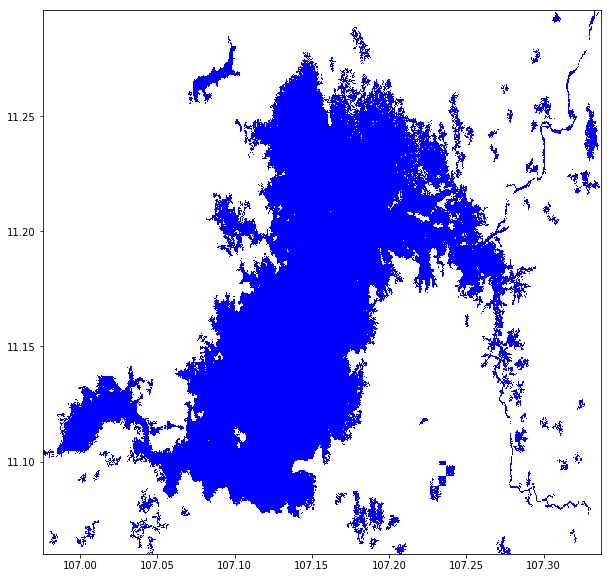

In [8]:
wasard.wasard_plot(alos_classified, sar_time_index = 0)

### Visualizing results: ALOS acquisition is pictured on the left; the same acquisition with the WASARD predictions is on the right 

<img src="alos_comparison.png">

#### Code for generating the above:

In [9]:
def plot_wasard(sar_dataset, imge, time_index):
    
    fig = plt.figure(figsize=(18,10))
    img = mpimg.imread(imge)
    
    a = fig.add_subplot(1,2,1)
    implot = plt.imshow(img, extent = [min_lon, max_lon, min_lat, max_lat])
   
    b = fig.add_subplot(1,2,2)
    
    implot = plt.imshow(img, extent = [min_lon, max_lon, min_lat, max_lat])
    wasard.wasard_plot(sar_dataset, time_index, plot_over_image=True)

<br>  

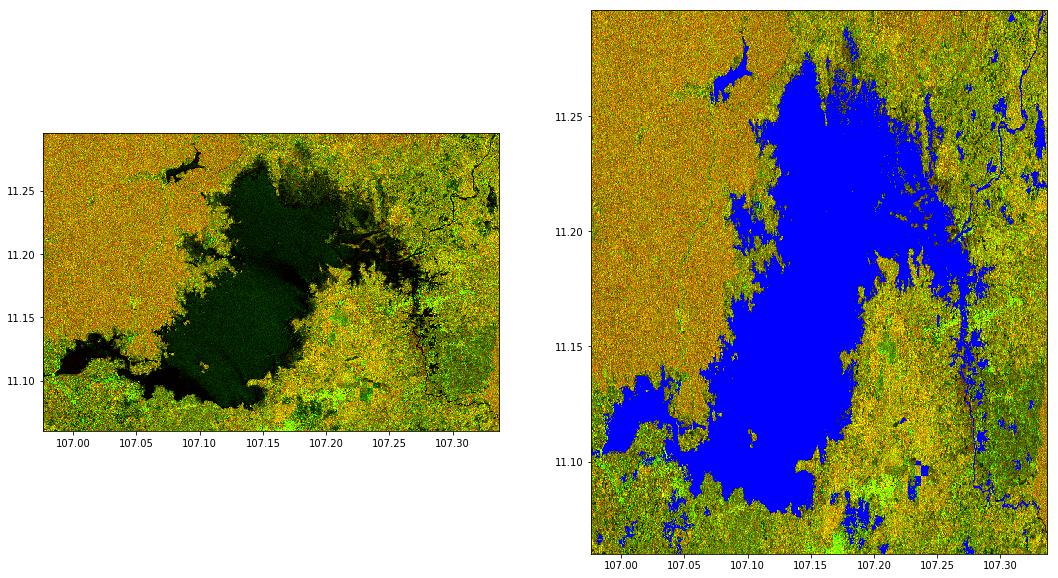

In [10]:
plot_wasard(alos_classified, 'alos2_img.png', 0)